# 通过OCR实现验证码识别

**作者:** [GT_老张](https://github.com/GT-ZhangAcer)  

**时间:** 2021.06

**摘要:** 本篇将介绍如何通过飞桨实现简单的CRNN+CTC自定义数据集OCR识别模型，数据集采用[CaptchaDataset](https://github.com/GT-ZhangAcer/CaptchaDataset)中OCR部分的9453张图像，其中前8453张图像在本案例中作为训练集，后1000张则作为测试集。  
在更复杂的场景中推荐使用[PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR)产出工业级模型，模型轻量且精度大幅提升。  
同样也可以在[PaddleHub](https://www.paddlepaddle.org.cn/hubdetail?name=chinese_ocr_db_crnn_mobile&en_category=TextRecognition)中快速使用PaddleOCR。

## 一、环境配置

本教程基于Paddle 2.1 编写，如果你的环境不是本版本，请先参考官网[安装](https://www.paddlepaddle.org.cn/install/quick) Paddle 2.1 。

In [1]:
import paddle
print(paddle.__version__)

2.1.1


## 二、自定义数据集读取器

常见的开发任务中，我们并不一定会拿到标准的数据格式，好在我们可以通过自定义Reader的形式来随心所欲读取自己想要数据。 

设计合理的Reader往往可以带来更好的性能，我们可以将读取标签文件列表、制作图像文件列表等必要操作在`__init__`特殊方法中实现。这样就可以在实例化`Reader`时装入内存，避免使用时频繁读取导致增加额外开销。同样我们可以在`__getitem__`特殊方法中实现如图像增强、归一化等个性操作，完成数据读取后即可释放该部分内存。    
需要我们注意的是，如果不能保证自己数据十分纯净，可以通过`try`和`expect`来捕获异常并指出该数据的位置。当然也可以制定一个策略，使其在发生数据读取异常后依旧可以正常进行训练。  

### 2.1 数据展示
![](https://ai-studio-static-online.cdn.bcebos.com/57d6c77aa5194cdca5c7edc533cc57e4d5070de95f6a4454b3cd1ca1e0eebe98)

点此[快速获取本节数据集](https://aistudio.baidu.com/aistudio/datasetdetail/57285)，待数据集下载完毕后可使用`!unzip OCR_Dataset.zip -d data/`命令或熟悉的解压软件进行解压，待数据准备工作完成后修改本文“训练准备”中的`DATA_PATH = 解压后数据集路径`。

In [2]:
# 下载数据集
!wget -O OCR_Dataset.zip https://bj.bcebos.com/v1/ai-studio-online/c91f50ef72de43b090298a38281e9c59a2d741eadd334f1cba7c710c5496e342?responseContentDisposition=attachment%3B%20filename%3DOCR_Dataset.zip&authorization=bce-auth-v1%2F0ef6765c1e494918bc0d4c3ca3e5c6d1%2F2020-10-27T09%3A50%3A21Z%2F-1%2F%2Fddc4aebed803af6c57dac46abba42d207961b78e7bc81744e8388395979b66fa
# 解压数据集
!unzip OCR_Dataset.zip -d data/

Archive:  OCR_Dataset.zip
   creating: data/OCR_Dataset/
  inflating: data/OCR_Dataset/63.jpg  
  inflating: data/OCR_Dataset/6400.jpg  
  inflating: data/OCR_Dataset/823.jpg  
  inflating: data/OCR_Dataset/4217.jpg  
  inflating: data/OCR_Dataset/3578.jpg  
  inflating: data/OCR_Dataset/2666.jpg  
  inflating: data/OCR_Dataset/5109.jpg  
  inflating: data/OCR_Dataset/2100.jpg  
  inflating: data/OCR_Dataset/4571.jpg  
  inflating: data/OCR_Dataset/7078.jpg  
  inflating: data/OCR_Dataset/1409.jpg  
  inflating: data/OCR_Dataset/9055.jpg  
  inflating: data/OCR_Dataset/6366.jpg  
  inflating: data/OCR_Dataset/189.jpg  
  inflating: data/OCR_Dataset/9041.jpg  
  inflating: data/OCR_Dataset/6372.jpg  
  inflating: data/OCR_Dataset/2114.jpg  
  inflating: data/OCR_Dataset/4565.jpg  
  inflating: data/OCR_Dataset/4203.jpg  
  inflating: data/OCR_Dataset/2672.jpg  
  inflating: data/OCR_Dataset/6414.jpg  
  inflating: data/OCR_Dataset/77.jpg  
  inflating: data/OCR_Dataset/8439.jpg  
  infl

/home/chenlong21/.conda/envs/paddle2.1/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



  inflating: data/OCR_Dataset/5875.jpg  
  inflating: data/OCR_Dataset/8389.jpg  
  inflating: data/OCR_Dataset/9097.jpg  
  inflating: data/OCR_Dataset/1420.jpg  
  inflating: data/OCR_Dataset/8362.jpg  
  inflating: data/OCR_Dataset/7051.jpg  
  inflating: data/OCR_Dataset/4558.jpg  
  inflating: data/OCR_Dataset/3237.jpg  
  inflating: data/OCR_Dataset/2129.jpg  
  inflating: data/OCR_Dataset/5646.jpg  
  inflating: data/OCR_Dataset/5120.jpg  
  inflating: data/OCR_Dataset/3551.jpg  
  inflating: data/OCR_Dataset/2897.jpg  
  inflating: data/OCR_Dataset/8404.jpg  
  inflating: data/OCR_Dataset/7737.jpg  
  inflating: data/OCR_Dataset/1346.jpg  
  inflating: data/OCR_Dataset/6429.jpg  
  inflating: data/OCR_Dataset/8410.jpg  
  inflating: data/OCR_Dataset/7723.jpg  
  inflating: data/OCR_Dataset/1352.jpg  
  inflating: data/OCR_Dataset/5134.jpg  
  inflating: data/OCR_Dataset/3545.jpg  
  inflating: data/OCR_Dataset/2883.jpg  
  inflating: data/OCR_Dataset/3223.jpg  
  inflating: da

  inflating: data/OCR_Dataset/8417.jpg  
  inflating: data/OCR_Dataset/7724.jpg  
  inflating: data/OCR_Dataset/8371.jpg  
  inflating: data/OCR_Dataset/7042.jpg  
  inflating: data/OCR_Dataset/1433.jpg  
  inflating: data/OCR_Dataset/5655.jpg  
  inflating: data/OCR_Dataset/3224.jpg  
  inflating: data/OCR_Dataset/8359.jpg  
  inflating: data/OCR_Dataset/6374.jpg  
  inflating: data/OCR_Dataset/9047.jpg  
  inflating: data/OCR_Dataset/2112.jpg  
  inflating: data/OCR_Dataset/4563.jpg  
  inflating: data/OCR_Dataset/4205.jpg  
  inflating: data/OCR_Dataset/2674.jpg  
  inflating: data/OCR_Dataset/6412.jpg  
  inflating: data/OCR_Dataset/71.jpg  
  inflating: data/OCR_Dataset/831.jpg  
  inflating: data/OCR_Dataset/1369.jpg  
  inflating: data/OCR_Dataset/65.jpg  
  inflating: data/OCR_Dataset/6406.jpg  
  inflating: data/OCR_Dataset/7718.jpg  
  inflating: data/OCR_Dataset/825.jpg  
  inflating: data/OCR_Dataset/4211.jpg  
  inflating: data/OCR_Dataset/2660.jpg  
  inflating: data/OCR_

  inflating: data/OCR_Dataset/832.jpg  
  inflating: data/OCR_Dataset/7069.jpg  
  inflating: data/OCR_Dataset/9044.jpg  
  inflating: data/OCR_Dataset/6377.jpg  
  inflating: data/OCR_Dataset/1418.jpg  
  inflating: data/OCR_Dataset/2111.jpg  
  inflating: data/OCR_Dataset/4560.jpg  
  inflating: data/OCR_Dataset/5695.jpg  
  inflating: data/OCR_Dataset/167.jpg  
  inflating: data/OCR_Dataset/7082.jpg  
  inflating: data/OCR_Dataset/1395.jpg  
  inflating: data/OCR_Dataset/601.jpg  
  inflating: data/OCR_Dataset/99.jpg  
  inflating: data/OCR_Dataset/3582.jpg  
  inflating: data/OCR_Dataset/2844.jpg  
  inflating: data/OCR_Dataset/2688.jpg  
  inflating: data/OCR_Dataset/3596.jpg  
  inflating: data/OCR_Dataset/2850.jpg  
  inflating: data/OCR_Dataset/7928.jpg  
  inflating: data/OCR_Dataset/615.jpg  
  inflating: data/OCR_Dataset/1381.jpg  
  inflating: data/OCR_Dataset/6388.jpg  
  inflating: data/OCR_Dataset/173.jpg  
  inflating: data/OCR_Dataset/7096.jpg  
  inflating: data/OCR_D

  inflating: data/OCR_Dataset/9220.jpg  
  inflating: data/OCR_Dataset/6113.jpg  
  inflating: data/OCR_Dataset/4704.jpg  
  inflating: data/OCR_Dataset/2375.jpg  
  inflating: data/OCR_Dataset/2413.jpg  
  inflating: data/OCR_Dataset/4062.jpg  
  inflating: data/OCR_Dataset/8658.jpg  
  inflating: data/OCR_Dataset/8880.jpg  
  inflating: data/OCR_Dataset/6675.jpg  
  inflating: data/OCR_Dataset/5354.jpg  
  inflating: data/OCR_Dataset/3725.jpg  
  inflating: data/OCR_Dataset/7543.jpg  
  inflating: data/OCR_Dataset/8670.jpg  
  inflating: data/OCR_Dataset/6885.jpg  
  inflating: data/OCR_Dataset/1132.jpg  
  inflating: data/OCR_Dataset/9208.jpg  
  inflating: data/OCR_Dataset/1654.jpg  
  inflating: data/OCR_Dataset/7225.jpg  
  inflating: data/OCR_Dataset/8116.jpg  
  inflating: data/OCR_Dataset/3043.jpg  
  inflating: data/OCR_Dataset/5432.jpg  
  inflating: data/OCR_Dataset/4738.jpg  
  inflating: data/OCR_Dataset/3057.jpg  
  inflating: data/OCR_Dataset/2349.jpg  
  inflating: dat

  inflating: data/OCR_Dataset/5579.jpg  
  inflating: data/OCR_Dataset/2216.jpg  
  inflating: data/OCR_Dataset/3108.jpg  
  inflating: data/OCR_Dataset/4667.jpg  
  inflating: data/OCR_Dataset/6070.jpg  
  inflating: data/OCR_Dataset/9343.jpg  
  inflating: data/OCR_Dataset/6716.jpg  
  inflating: data/OCR_Dataset/9425.jpg  
  inflating: data/OCR_Dataset/1079.jpg  
  inflating: data/OCR_Dataset/7408.jpg  
  inflating: data/OCR_Dataset/4101.jpg  
  inflating: data/OCR_Dataset/2570.jpg  
  inflating: data/OCR_Dataset/1051.jpg  
  inflating: data/OCR_Dataset/8713.jpg  
  inflating: data/OCR_Dataset/7420.jpg  
  inflating: data/OCR_Dataset/4129.jpg  
  inflating: data/OCR_Dataset/3646.jpg  
  inflating: data/OCR_Dataset/2558.jpg  
  inflating: data/OCR_Dataset/5237.jpg  
  inflating: data/OCR_Dataset/5551.jpg  
  inflating: data/OCR_Dataset/4897.jpg  
  inflating: data/OCR_Dataset/3120.jpg  
  inflating: data/OCR_Dataset/8075.jpg  
  inflating: data/OCR_Dataset/7346.jpg  
  inflating: dat

  inflating: data/OCR_Dataset/3858.jpg  
  inflating: data/OCR_Dataset/3680.jpg  
  inflating: data/OCR_Dataset/6920.jpg  
  inflating: data/OCR_Dataset/1097.jpg  
  inflating: data/OCR_Dataset/503.jpg  
  inflating: data/OCR_Dataset/6934.jpg  
  inflating: data/OCR_Dataset/517.jpg  
  inflating: data/OCR_Dataset/1083.jpg  
  inflating: data/OCR_Dataset/8919.jpg  
  inflating: data/OCR_Dataset/3694.jpg  
  inflating: data/OCR_Dataset/4845.jpg  
  inflating: data/OCR_Dataset/5583.jpg  
  inflating: data/OCR_Dataset/271.jpg  
  inflating: data/OCR_Dataset/7394.jpg  
  inflating: data/OCR_Dataset/9391.jpg  
  inflating: data/OCR_Dataset/259.jpg  
  inflating: data/OCR_Dataset/1915.jpg  
  inflating: data/OCR_Dataset/8931.jpg  
  inflating: data/OCR_Dataset/3864.jpg  
  inflating: data/OCR_Dataset/3870.jpg  
  inflating: data/OCR_Dataset/6908.jpg  
  inflating: data/OCR_Dataset/8925.jpg  
  inflating: data/OCR_Dataset/9385.jpg  
  inflating: data/OCR_Dataset/1901.jpg  
  inflating: data/OC

  inflating: data/OCR_Dataset/7383.jpg  
  inflating: data/OCR_Dataset/4852.jpg  
  inflating: data/OCR_Dataset/5594.jpg  
  inflating: data/OCR_Dataset/9386.jpg  
  inflating: data/OCR_Dataset/8098.jpg  
  inflating: data/OCR_Dataset/1902.jpg  
  inflating: data/OCR_Dataset/3873.jpg  
  inflating: data/OCR_Dataset/8926.jpg  
  inflating: data/OCR_Dataset/528.jpg  
  inflating: data/OCR_Dataset/8932.jpg  
  inflating: data/OCR_Dataset/3867.jpg  
  inflating: data/OCR_Dataset/9392.jpg  
  inflating: data/OCR_Dataset/1916.jpg  
  inflating: data/OCR_Dataset/8503.jpg  
  inflating: data/OCR_Dataset/7630.jpg  
  inflating: data/OCR_Dataset/1241.jpg  
  inflating: data/OCR_Dataset/2748.jpg  
  inflating: data/OCR_Dataset/5027.jpg  
  inflating: data/OCR_Dataset/4339.jpg  
  inflating: data/OCR_Dataset/2990.jpg  
  inflating: data/OCR_Dataset/3456.jpg  
  inflating: data/OCR_Dataset/5999.jpg  
  inflating: data/OCR_Dataset/3330.jpg  
  inflating: data/OCR_Dataset/5741.jpg  
  inflating: data

  inflating: data/OCR_Dataset/3314.jpg  
  inflating: data/OCR_Dataset/5765.jpg  
  inflating: data/OCR_Dataset/5003.jpg  
  inflating: data/OCR_Dataset/3472.jpg  
  inflating: data/OCR_Dataset/8527.jpg  
  inflating: data/OCR_Dataset/929.jpg  
  inflating: data/OCR_Dataset/7614.jpg  
  inflating: data/OCR_Dataset/1265.jpg  
  inflating: data/OCR_Dataset/8533.jpg  
  inflating: data/OCR_Dataset/7600.jpg  
  inflating: data/OCR_Dataset/1271.jpg  
  inflating: data/OCR_Dataset/5017.jpg  
  inflating: data/OCR_Dataset/2778.jpg  
  inflating: data/OCR_Dataset/3466.jpg  
  inflating: data/OCR_Dataset/4309.jpg  
  inflating: data/OCR_Dataset/3300.jpg  
  inflating: data/OCR_Dataset/5771.jpg  
  inflating: data/OCR_Dataset/6278.jpg  
  inflating: data/OCR_Dataset/1517.jpg  
  inflating: data/OCR_Dataset/8255.jpg  
  inflating: data/OCR_Dataset/7166.jpg  
  inflating: data/OCR_Dataset/6293.jpg  
  inflating: data/OCR_Dataset/4484.jpg  
  inflating: data/OCR_Dataset/5942.jpg  
  inflating: data

  inflating: data/OCR_Dataset/5954.jpg  
  inflating: data/OCR_Dataset/4492.jpg  
  inflating: data/OCR_Dataset/2785.jpg  
  inflating: data/OCR_Dataset/7825.jpg  
  inflating: data/OCR_Dataset/718.jpg  
  inflating: data/OCR_Dataset/6508.jpg  
  inflating: data/OCR_Dataset/1267.jpg  
  inflating: data/OCR_Dataset/8525.jpg  
  inflating: data/OCR_Dataset/7616.jpg  
  inflating: data/OCR_Dataset/3470.jpg  
  inflating: data/OCR_Dataset/5001.jpg  
  inflating: data/OCR_Dataset/5767.jpg  
  inflating: data/OCR_Dataset/2008.jpg  
  inflating: data/OCR_Dataset/3316.jpg  
  inflating: data/OCR_Dataset/4479.jpg  
  inflating: data/OCR_Dataset/8243.jpg  
  inflating: data/OCR_Dataset/7170.jpg  
  inflating: data/OCR_Dataset/1501.jpg  
  inflating: data/OCR_Dataset/8257.jpg  
  inflating: data/OCR_Dataset/7164.jpg  
  inflating: data/OCR_Dataset/1515.jpg  
  inflating: data/OCR_Dataset/9149.jpg  
  inflating: data/OCR_Dataset/5773.jpg  
  inflating: data/OCR_Dataset/3302.jpg  
  inflating: data

  inflating: data/OCR_Dataset/5010.jpg  
  inflating: data/OCR_Dataset/1276.jpg  
  inflating: data/OCR_Dataset/6519.jpg  
  inflating: data/OCR_Dataset/8534.jpg  
  inflating: data/OCR_Dataset/7607.jpg  
  inflating: data/OCR_Dataset/8252.jpg  
  inflating: data/OCR_Dataset/7161.jpg  
  inflating: data/OCR_Dataset/1510.jpg  
  inflating: data/OCR_Dataset/2019.jpg  
  inflating: data/OCR_Dataset/5776.jpg  
  inflating: data/OCR_Dataset/4468.jpg  
  inflating: data/OCR_Dataset/3307.jpg  
  inflating: data/OCR_Dataset/3688.jpg  
  inflating: data/OCR_Dataset/2596.jpg  
  inflating: data/OCR_Dataset/3850.jpg  
  inflating: data/OCR_Dataset/8905.jpg  
  inflating: data/OCR_Dataset/6928.jpg  
  inflating: data/OCR_Dataset/1921.jpg  
  inflating: data/OCR_Dataset/7388.jpg  
  inflating: data/OCR_Dataset/6096.jpg  
  inflating: data/OCR_Dataset/4859.jpg  
  inflating: data/OCR_Dataset/4681.jpg  
  inflating: data/OCR_Dataset/4695.jpg  
  inflating: data/OCR_Dataset/1935.jpg  
  inflating: dat

  inflating: data/OCR_Dataset/1739.jpg  
  inflating: data/OCR_Dataset/6056.jpg  
  inflating: data/OCR_Dataset/9365.jpg  
  inflating: data/OCR_Dataset/7348.jpg  
  inflating: data/OCR_Dataset/6730.jpg  
  inflating: data/OCR_Dataset/9403.jpg  
  inflating: data/OCR_Dataset/2556.jpg  
  inflating: data/OCR_Dataset/3890.jpg  
  inflating: data/OCR_Dataset/5239.jpg  
  inflating: data/OCR_Dataset/4127.jpg  
  inflating: data/OCR_Dataset/3648.jpg  
  inflating: data/OCR_Dataset/8735.jpg  
  inflating: data/OCR_Dataset/7406.jpg  
  inflating: data/OCR_Dataset/6718.jpg  
  inflating: data/OCR_Dataset/1077.jpg  
  inflating: data/OCR_Dataset/5211.jpg  
  inflating: data/OCR_Dataset/3660.jpg  
  inflating: data/OCR_Dataset/3106.jpg  
  inflating: data/OCR_Dataset/4669.jpg  
  inflating: data/OCR_Dataset/5577.jpg  
  inflating: data/OCR_Dataset/2218.jpg  
  inflating: data/OCR_Dataset/1711.jpg  
  inflating: data/OCR_Dataset/285.jpg  
  inflating: data/OCR_Dataset/8053.jpg  
  inflating: data

  inflating: data/OCR_Dataset/4960.jpg  
  inflating: data/OCR_Dataset/354.jpg  
  inflating: data/OCR_Dataset/1818.jpg  
  inflating: data/OCR_Dataset/8182.jpg  
  inflating: data/OCR_Dataset/340.jpg  
  inflating: data/OCR_Dataset/9288.jpg  
  inflating: data/OCR_Dataset/8196.jpg  
  inflating: data/OCR_Dataset/4974.jpg  
  inflating: data/OCR_Dataset/6805.jpg  
  inflating: data/OCR_Dataset/8828.jpg  
  inflating: data/OCR_Dataset/426.jpg  
  inflating: data/OCR_Dataset/2493.jpg  
  inflating: data/OCR_Dataset/3955.jpg  
  inflating: data/OCR_Dataset/8800.jpg  
  inflating: data/OCR_Dataset/368.jpg  
  inflating: data/OCR_Dataset/6193.jpg  
  inflating: data/OCR_Dataset/1824.jpg  
  inflating: data/OCR_Dataset/4784.jpg  
  inflating: data/OCR_Dataset/4790.jpg  
  inflating: data/OCR_Dataset/4948.jpg  
  inflating: data/OCR_Dataset/6187.jpg  
  inflating: data/OCR_Dataset/1830.jpg  
  inflating: data/OCR_Dataset/7299.jpg  
  inflating: data/OCR_Dataset/6839.jpg  
  inflating: data/OC

  inflating: data/OCR_Dataset/3771.jpg  
  inflating: data/OCR_Dataset/5300.jpg  
  inflating: data/OCR_Dataset/6609.jpg  
  inflating: data/OCR_Dataset/1166.jpg  
  inflating: data/OCR_Dataset/8624.jpg  
  inflating: data/OCR_Dataset/7517.jpg  
  inflating: data/OCR_Dataset/4036.jpg  
  inflating: data/OCR_Dataset/3759.jpg  
  inflating: data/OCR_Dataset/2447.jpg  
  inflating: data/OCR_Dataset/3981.jpg  
  inflating: data/OCR_Dataset/5328.jpg  
  inflating: data/OCR_Dataset/6621.jpg  
  inflating: data/OCR_Dataset/7259.jpg  
  inflating: data/OCR_Dataset/1628.jpg  
  inflating: data/OCR_Dataset/6147.jpg  
  inflating: data/OCR_Dataset/9274.jpg  
  inflating: data/OCR_Dataset/2321.jpg  
  inflating: data/OCR_Dataset/4988.jpg  
  inflating: data/OCR_Dataset/4750.jpg  
  inflating: data/OCR_Dataset/2335.jpg  
  inflating: data/OCR_Dataset/4744.jpg  
  inflating: data/OCR_Dataset/6153.jpg  
  inflating: data/OCR_Dataset/9260.jpg  
  inflating: data/OCR_Dataset/6635.jpg  
  inflating: dat

  inflating: data/OCR_Dataset/7738.jpg  
  inflating: data/OCR_Dataset/6426.jpg  
  inflating: data/OCR_Dataset/45.jpg  
  inflating: data/OCR_Dataset/1349.jpg  
  inflating: data/OCR_Dataset/2640.jpg  
  inflating: data/OCR_Dataset/4231.jpg  
  inflating: data/OCR_Dataset/2898.jpg  
  inflating: data/OCR_Dataset/5891.jpg  
  inflating: data/OCR_Dataset/3238.jpg  
  inflating: data/OCR_Dataset/4557.jpg  
  inflating: data/OCR_Dataset/5649.jpg  
  inflating: data/OCR_Dataset/2126.jpg  
  inflating: data/OCR_Dataset/9073.jpg  
  inflating: data/OCR_Dataset/6340.jpg  
  inflating: data/OCR_Dataset/9067.jpg  
  inflating: data/OCR_Dataset/6354.jpg  
  inflating: data/OCR_Dataset/8379.jpg  
  inflating: data/OCR_Dataset/5885.jpg  
  inflating: data/OCR_Dataset/3.jpg  
  inflating: data/OCR_Dataset/4543.jpg  
  inflating: data/OCR_Dataset/2132.jpg  
  inflating: data/OCR_Dataset/2654.jpg  
  inflating: data/OCR_Dataset/4225.jpg  
  inflating: data/OCR_Dataset/811.jpg  
  inflating: data/OCR_

  inflating: data/OCR_Dataset/3213.jpg  
  inflating: data/OCR_Dataset/5662.jpg  
  inflating: data/OCR_Dataset/190.jpg  
  inflating: data/OCR_Dataset/1404.jpg  
  inflating: data/OCR_Dataset/9058.jpg  
  inflating: data/OCR_Dataset/8346.jpg  
  inflating: data/OCR_Dataset/7075.jpg  
  inflating: data/OCR_Dataset/1410.jpg  
  inflating: data/OCR_Dataset/184.jpg  
  inflating: data/OCR_Dataset/8352.jpg  
  inflating: data/OCR_Dataset/7061.jpg  
  inflating: data/OCR_Dataset/3207.jpg  
  inflating: data/OCR_Dataset/4568.jpg  
  inflating: data/OCR_Dataset/5676.jpg  
  inflating: data/OCR_Dataset/2119.jpg  
  inflating: data/OCR_Dataset/5110.jpg  
  inflating: data/OCR_Dataset/3561.jpg  
  inflating: data/OCR_Dataset/8434.jpg  
  inflating: data/OCR_Dataset/7707.jpg  
  inflating: data/OCR_Dataset/6419.jpg  
  inflating: data/OCR_Dataset/1376.jpg  


In [3]:
import os

import PIL.Image as Image
import numpy as np
from paddle.io import Dataset

# 图片信息配置 - 通道数、高度、宽度
IMAGE_SHAPE_C = 3
IMAGE_SHAPE_H = 30
IMAGE_SHAPE_W = 70
# 数据集图片中标签长度最大值设置 - 因图片中均为4个字符，故该处填写为4即可
LABEL_MAX_LEN = 4


class Reader(Dataset):
    def __init__(self, data_path: str, is_val: bool = False):
        """
        数据读取Reader
        :param data_path: Dataset路径
        :param is_val: 是否为验证集
        """
        super().__init__()
        self.data_path = data_path
        # 读取Label字典
        with open(os.path.join(self.data_path, "label_dict.txt"), "r", encoding="utf-8") as f:
            self.info = eval(f.read())
        # 获取文件名列表
        self.img_paths = [img_name for img_name in self.info]
        # 将数据集后1000张图片设置为验证集，当is_val为真时img_path切换为后1000张
        self.img_paths = self.img_paths[-1000:] if is_val else self.img_paths[:-1000]

    def __getitem__(self, index):
        # 获取第index个文件的文件名以及其所在路径
        file_name = self.img_paths[index]
        file_path = os.path.join(self.data_path, file_name)
        # 捕获异常 - 在发生异常时终止训练
        try:
            # 使用Pillow来读取图像数据
            img = Image.open(file_path)
            # 转为Numpy的array格式并整体除以255进行归一化
            img = np.array(img, dtype="float32").reshape((IMAGE_SHAPE_C, IMAGE_SHAPE_H, IMAGE_SHAPE_W)) / 255
        except Exception as e:
            raise Exception(file_name + "\t文件打开失败，请检查路径是否准确以及图像文件完整性，报错信息如下:\n" + str(e))
        # 读取该图像文件对应的Label字符串，并进行处理
        label = self.info[file_name]
        label = list(label)
        # 将label转化为Numpy的array格式
        label = np.array(label, dtype="int32").reshape(LABEL_MAX_LEN)

        return img, label

    def __len__(self):
        # 返回每个Epoch中图片数量
        return len(self.img_paths)

## 三、模型配置

### 3.1 定义模型结构以及模型输入

模型方面使用的简单的CRNN-CTC结构，输入形为CHW的图像在经过CNN->Flatten->Linear->RNN->Linear后输出图像中每个位置所对应的字符概率。考虑到CTC解码器在面对图像中元素数量不一、相邻元素重复时会存在无法正确对齐等情况，故额外添加一个类别代表“分隔符”进行改善。

CTC相关论文：[Connectionist Temporal Classification: Labelling Unsegmented Sequence Data with Recurrent Neu](http://people.idsia.ch/~santiago/papers/icml2006.pdf) 

![](https://ai-studio-static-online.cdn.bcebos.com/8ce1fce57f9f47c5b19a4e61caae7e6330b1b42dde1c4f4593d2181fbf474b8b)


网络部分，因本篇采用数据集较为简单且图像尺寸较小并不适合较深层次网络。若在对尺寸较大的图像进行模型构建，可以考虑使用更深层次网络/注意力机制来完成。当然也可以通过目标检测形式先检出文本位置，然后进行OCR部分模型构建。

![](https://ai-studio-static-online.cdn.bcebos.com/19ddf6107e7f47ee9b3b84ee0c12de1e15f7ab8b88f04eed95232440c92fe0d7)

<a href="https://github.com/PaddlePaddle/PaddleOCR">PaddleOCR效果图</a>
</p>

In [4]:
import paddle

# 分类数量设置 - 因数据集中共包含0~9共10种数字+分隔符，所以是11分类任务
CLASSIFY_NUM = 11

# 定义输入层，shape中第0维使用-1则可以在预测时自由调节batch size
input_define = paddle.static.InputSpec(shape=[-1, IMAGE_SHAPE_C, IMAGE_SHAPE_H, IMAGE_SHAPE_W],
                                   dtype="float32",
                                   name="img")

# 定义网络结构
class Net(paddle.nn.Layer):
    def __init__(self, is_infer: bool = False):
        super().__init__()
        self.is_infer = is_infer

        # 定义一层3x3卷积+BatchNorm
        self.conv1 = paddle.nn.Conv2D(in_channels=IMAGE_SHAPE_C,
                                  out_channels=32,
                                  kernel_size=3)
        self.bn1 = paddle.nn.BatchNorm2D(32)
        # 定义一层步长为2的3x3卷积进行下采样+BatchNorm
        self.conv2 = paddle.nn.Conv2D(in_channels=32,
                                  out_channels=64,
                                  kernel_size=3,
                                  stride=2)
        self.bn2 = paddle.nn.BatchNorm2D(64)
        # 定义一层1x1卷积压缩通道数，输出通道数设置为比LABEL_MAX_LEN稍大的定值可获取更优效果，当然也可设置为LABEL_MAX_LEN
        self.conv3 = paddle.nn.Conv2D(in_channels=64,
                                  out_channels=LABEL_MAX_LEN + 4,
                                  kernel_size=1)
        # 定义全连接层，压缩并提取特征（可选）
        self.linear = paddle.nn.Linear(in_features=429,
                                   out_features=128)
        # 定义RNN层来更好提取序列特征，此处为双向LSTM输出为2 x hidden_size，可尝试换成GRU等RNN结构
        self.lstm = paddle.nn.LSTM(input_size=128,
                               hidden_size=64,
                               direction="bidirectional")
        # 定义输出层，输出大小为分类数
        self.linear2 = paddle.nn.Linear(in_features=64 * 2,
                                    out_features=CLASSIFY_NUM)

    def forward(self, ipt):
        # 卷积 + ReLU + BN
        x = self.conv1(ipt)
        x = paddle.nn.functional.relu(x)
        x = self.bn1(x)
        # 卷积 + ReLU + BN
        x = self.conv2(x)
        x = paddle.nn.functional.relu(x)
        x = self.bn2(x)
        # 卷积 + ReLU
        x = self.conv3(x)
        x = paddle.nn.functional.relu(x)
        # 将3维特征转换为2维特征 - 此处可以使用reshape代替
        x = paddle.tensor.flatten(x, 2)
        # 全连接 + ReLU
        x = self.linear(x)
        x = paddle.nn.functional.relu(x)
        # 双向LSTM - [0]代表取双向结果，[1][0]代表forward结果,[1][1]代表backward结果，详细说明可在官方文档中搜索'LSTM'
        x = self.lstm(x)[0]
        # 输出层 - Shape = (Batch Size, Max label len, Signal) 
        x = self.linear2(x)

        # 在计算损失时ctc-loss会自动进行softmax，所以在预测模式中需额外做softmax获取标签概率
        if self.is_infer:
            # 输出层 - Shape = (Batch Size, Max label len, Prob) 
            x = paddle.nn.functional.softmax(x)
            # 转换为标签
            x = paddle.argmax(x, axis=-1)
        return x

## 四、训练准备

### 4.1 定义label输入以及超参数
监督训练需要定义label，预测则不需要该步骤。

In [5]:
# 数据集路径设置
DATA_PATH = "./data/OCR_Dataset"
# 训练轮数
EPOCH = 10
# 每批次数据大小
BATCH_SIZE = 16

label_define = paddle.static.InputSpec(shape=[-1, LABEL_MAX_LEN],
                                    dtype="int32",
                                    name="label")

### 4.2 定义CTC Loss

了解CTC解码器效果后，我们需要在训练中让模型尽可能接近这种类型输出形式，那么我们需要定义一个CTC Loss来计算模型损失。不必担心，在飞桨框架中内置了多种Loss，无需手动复现即可完成损失计算。
 
使用文档：[CTCLoss](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-beta/api/paddle/nn/functional/loss/ctc_loss_cn.html#ctc-loss)

In [6]:
class CTCLoss(paddle.nn.Layer):
    def __init__(self):
        """
        定义CTCLoss
        """
        super().__init__()

    def forward(self, ipt, label):
        input_lengths = paddle.full(shape=[BATCH_SIZE, 1],fill_value=LABEL_MAX_LEN + 4,dtype= "int64")
        label_lengths = paddle.full(shape=[BATCH_SIZE, 1],fill_value=LABEL_MAX_LEN,dtype= "int64")
        # 按文档要求进行转换dim顺序
        ipt = paddle.tensor.transpose(ipt, [1, 0, 2])
        # 计算loss
        loss = paddle.nn.functional.ctc_loss(ipt, label, input_lengths, label_lengths, blank=10)
        return loss

### 4.3 实例化模型并配置优化策略

In [7]:
# 实例化模型
model = paddle.Model(Net(), inputs=input_define, labels=label_define)

In [10]:
# 定义优化器
optimizer = paddle.optimizer.Adam(learning_rate=0.0001, parameters=model.parameters())

# 为模型配置运行环境并设置该优化策略
model.prepare(optimizer=optimizer,
                loss=CTCLoss())

## 五、开始训练


In [11]:
# 执行训练
model.fit(train_data=Reader(DATA_PATH),
            eval_data=Reader(DATA_PATH, is_val=True),
            batch_size=BATCH_SIZE,
            epochs=EPOCH,
            save_dir="output/",
            save_freq=1,
            verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/10
step 529/529 [==============================] - loss: 0.4699 - 16ms/step          
save checkpoint at /home/chenlong21/online_repo/book/paddle2.0_docs/image_ocr/output/0
Eval begin...
step 63/63 [==============================] - loss: 0.5287 - 9ms/step          
Eval samples: 1000
Epoch 2/10
step 529/529 [==============================] - loss: 0.1224 - 16ms/step          
save checkpoint at /home/chenlong21/online_repo/book/paddle2.0_docs/image_ocr/output/1
Eval begin...
step 63/63 [==============================] - loss: 0.2269 - 10ms/step          
Eval samples: 1000
Epoch 3/10
step 529/529 [==============================] - loss: 0.1730 - 16ms/step          
save checkpoint at /home/chenlong21/online_repo/book/paddle2.0_docs/image_ocr/output/2
Eval begin...
step 63/63 [==============================] - loss: 0.1182 - 9ms/step          
Eval samples: 1000
Epoch 4

## 六、预测前准备

### 6.1 像定义训练Reader一样定义预测Reader

In [12]:
# 与训练近似，但不包含Label
class InferReader(Dataset):
    def __init__(self, dir_path=None, img_path=None):
        """
        数据读取Reader(预测)
        :param dir_path: 预测对应文件夹（二选一）
        :param img_path: 预测单张图片（二选一）
        """
        super().__init__()
        if dir_path:
            # 获取文件夹中所有图片路径
            self.img_names = [i for i in os.listdir(dir_path) if os.path.splitext(i)[1] == ".jpg"]
            self.img_paths = [os.path.join(dir_path, i) for i in self.img_names]
        elif img_path:
            self.img_names = [os.path.split(img_path)[1]]
            self.img_paths = [img_path]
        else:
            raise Exception("请指定需要预测的文件夹或对应图片路径")

    def get_names(self):
        """
        获取预测文件名顺序 
        """
        return self.img_names

    def __getitem__(self, index):
        # 获取图像路径
        file_path = self.img_paths[index]
        # 使用Pillow来读取图像数据并转成Numpy格式
        img = Image.open(file_path)
        img = np.array(img, dtype="float32").reshape((IMAGE_SHAPE_C, IMAGE_SHAPE_H, IMAGE_SHAPE_W)) / 255
        return img

    def __len__(self):
        return len(self.img_paths)

### 6.2 参数设置

In [13]:
# 待预测目录 - 可在测试数据集中挑出\b3张图像放在该目录中进行推理
INFER_DATA_PATH = "./sample_img"
# 训练后存档点路径 - final 代表最终训练所得模型
CHECKPOINT_PATH = "./output/final.pdparams"
# 每批次处理数量
BATCH_SIZE = 32

### 6.3 展示待预测数据

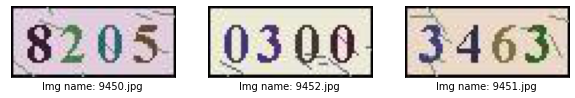

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sample_idxs = np.random.choice(50000, size=25, replace=False)

for img_id, img_name in enumerate(os.listdir(INFER_DATA_PATH)):
    plt.subplot(1, 3, img_id + 1)
    plt.xticks([])
    plt.yticks([])
    im = Image.open(os.path.join(INFER_DATA_PATH, img_name))
    plt.imshow(im, cmap=plt.cm.binary)
    plt.xlabel("Img name: " + img_name)
plt.show()

## 七、开始预测
> 飞桨2.1 CTC Decoder 相关API正在迁移中，本节暂时使用简易版解码器。

In [16]:
# 编写简易版解码器
def ctc_decode(text, blank=10):
    """
    简易CTC解码器
    :param text: 待解码数据
    :param blank: 分隔符索引值
    :return: 解码后数据
    """
    result = []
    cache_idx = -1
    for char in text:
        if char != blank and char != cache_idx:
            result.append(char)
        cache_idx = char
    return result


# 实例化推理模型
model = paddle.Model(Net(is_infer=True), inputs=input_define)
# 加载训练好的参数模型
model.load(CHECKPOINT_PATH)
# 设置运行环境
model.prepare()

# 加载预测Reader
infer_reader = InferReader(INFER_DATA_PATH)
img_names = infer_reader.get_names()
results = model.predict(infer_reader, batch_size=BATCH_SIZE)
index = 0
for text_batch in results[0]:
    for prob in text_batch:
        out = ctc_decode(prob, blank=10)
        print(f"文件名：{img_names[index]}，推理结果为：{out}")
        index += 1


import numpy as np
from paddle.io import DataLoader, Dataset

class RandomDataset(Dataset):
    def __getitem__(self, idx):
        data = np.random.random((2, 3)).astype('float32')

        return data

    def __len__(self):
        return 10

dataset = RandomDataset()
loader = DataLoader(dataset, batch_size=1)
data = next(loader())

In Paddle <= 2.0, data is in format '[Tensor(shape=(1, 2, 3), dtype=float32)]', and in Paddle >= 2.1, data is in format 'Tensor(shape=(1, 2, 3), dtype=float32)'


import numpy as np
from paddle.io import DataLoader, Dataset

class RandomDataset(Dataset):
    def __getitem__(self, idx):
        data = np.random.random((2, 3)).astype('float32')

        return data

    def __len__(self):
        return 10

dataset = RandomDataset()
loader = DataLoader(dataset, batch_size=1)
data = next(loader())

In Paddle <= 2.0, data is in format '[Tensor(shape=(1, 2, 3), dtype=float32)]', and in Paddle >= 2.1, data is in format 'Tensor(shape=(1, 2, 3), dtype=float32)'

Predict begin...
step 1/1 [==============================] - 11ms/step
Predict samples: 3
文件名：9450.jpg，推理结果为：[8, 2, 0, 5]
文件名：9452.jpg，推理结果为：[0, 3, 0, 0]
文件名：9451.jpg，推理结果为：[3, 4, 6, 3]
